In [2]:
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os 
import pandas as pd

In [3]:
all_books = [b for b in os.scandir('data') if '.txt' in b.name]  

In [4]:
NER = spacy.load('en_core_web_sm')
NER.max_length = 1651917

In [5]:
all_books

[<DirEntry 'got.txt'>]

In [6]:
got = all_books[0]
text = open(got , encoding="utf8").read()
book_doc = NER(text)

In [7]:
displacy.render(book_doc[0:2000],style="ent",jupyter = "true")

In [8]:
characters = pd.read_csv("Data\char.csv")

In [9]:
pd.DataFrame(characters)

,Names
0,Robert Baratheon
1,Tyrion Lannister
2,Cersei Lannister
3,Catelyn Stark
4,Jaime Lannister
...,...
74,High Priestess
75,Randyll Tarly
76,Izembaro
77,Brother Ray


In [10]:
characters['character_firstname'] = characters['Names'].apply(lambda x: x.split(' ', 1)[0])

In [11]:
sent_entity_df = []
# Loop through sentences, store named entity list for each sentence 
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents] 
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
sent_entity_df = pd.DataFrame(sent_entity_df)

In [12]:
sent_entity_df

,sentence,entities
0,(\n\n ...,[]
1,"(“, The, \n, wildlings, are, dead, ., ”, \n\n,...",[]
2,"(Ser, Waymar, Royce, asked, with, just, the, h...",[Waymar Royce]
3,"(Gared, did, not, rise, to, the, bait, .)",[Gared]
4,"(He, was, an, old, man, ,, past, fifty, ,, and...",[fifty]
...,...,...
24642,"(161, -, 171, \n , Baelor, I, \n ,...","[161, Beloved, Blessed, septon, king, second, ..."
24643,"([, His, , younger, brother, ,, Prince, Aemon...","[Prince Aemon, Queen Naerys, 184, Aegon, Aemon]"
24644,"([, Daeron, , brought, Dorne, into, , the, r...","[Daeron, Dornish, Myriah, 209, 754, second, Da..."
24645,"(221, -, 233, \n , Maekar, I, \n , ...","[221, Maekar, fourth, Daeron II, 233, Unlikely..."


In [13]:
def filter_entity (ent_list, characters): 
    return [ent for ent in ent_list 
            if ent in list(characters.Names) 
            or ent in list(characters.character_firstname)]

In [14]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters))

# Filter out sentences that don't have any character entities 
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0] 
sent_entity_df_filtered

,sentence,entities,character_entities
127,"(Gared, glared, at, the, lordling, ,, the, sca...","[Gared, Maester Aemon]",[Maester Aemon]
333,"(“, For, Robert, !, ”)",[Robert],[Robert]
356,"(Gared, would, know, what, to, make, of, it, ,...","[Mormont, Maester Aemon]",[Maester Aemon]
373,"(Robb, thought, he, was, a, \n, wildling, ,, h...",[Mance Rayder],[Mance Rayder]
382,"(Robb, and, Jon, sat, \n, tall, and, still, on...",[Jon],[Jon]
...,...,...,...
24584,"(TYWIN, LANNISTER, ,, Lord, of, Casterly, , R...","[Casterly Rock, Warden, Shield, JAIME, Kingsl...","[Cersei, Jaime]"
24637,"(I, \n , the, Old, King, ,, the, Conciliato...","[Aenys, 103, Jaehaerys, 129-131, Aegon, II, Vi...",[Viserys]
24642,"(161, -, 171, \n , Baelor, I, \n ,...","[161, Beloved, Blessed, septon, king, second, ...",[Viserys]
24645,"(221, -, 233, \n , Maekar, I, \n , ...","[221, Maekar, fourth, Daeron II, 233, Unlikely...",[Robert Baratheon]


In [15]:
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

C:\Users\shubh\AppData\Local\Temp\ipykernel_28600\2127265797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [16]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [17]:
relationship_df = pd.DataFrame(relationships)

In [18]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Robert,Jon
1,Robert,Jon
2,Robert,Jon
3,Robert,Jon
4,Jon,Robb
5,Jon,Robb
6,Robb,Jon
7,Jon,Robb
8,Jon,Robb
9,Robb,Jon


In [19]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Jon,Robert
1,Jon,Robert
2,Jon,Robert
3,Jon,Robert
4,Jon,Robb
5,Jon,Robb
6,Jon,Robb
7,Jon,Robb
8,Jon,Robb
9,Jon,Robb


In [20]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [21]:
relationship_df.head(10)

,source,target,value
0,Jon,Robert,72
1,Jon,Robb,73
2,Bran,Robb,41
3,Jon,Theon,27
4,Bran,Theon,22
5,Jon,Rickon,54
6,Bran,Jon,45
7,Catelyn,Jon,60
8,Rickon,Sansa,12
9,Bran,Catelyn,42


In [22]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

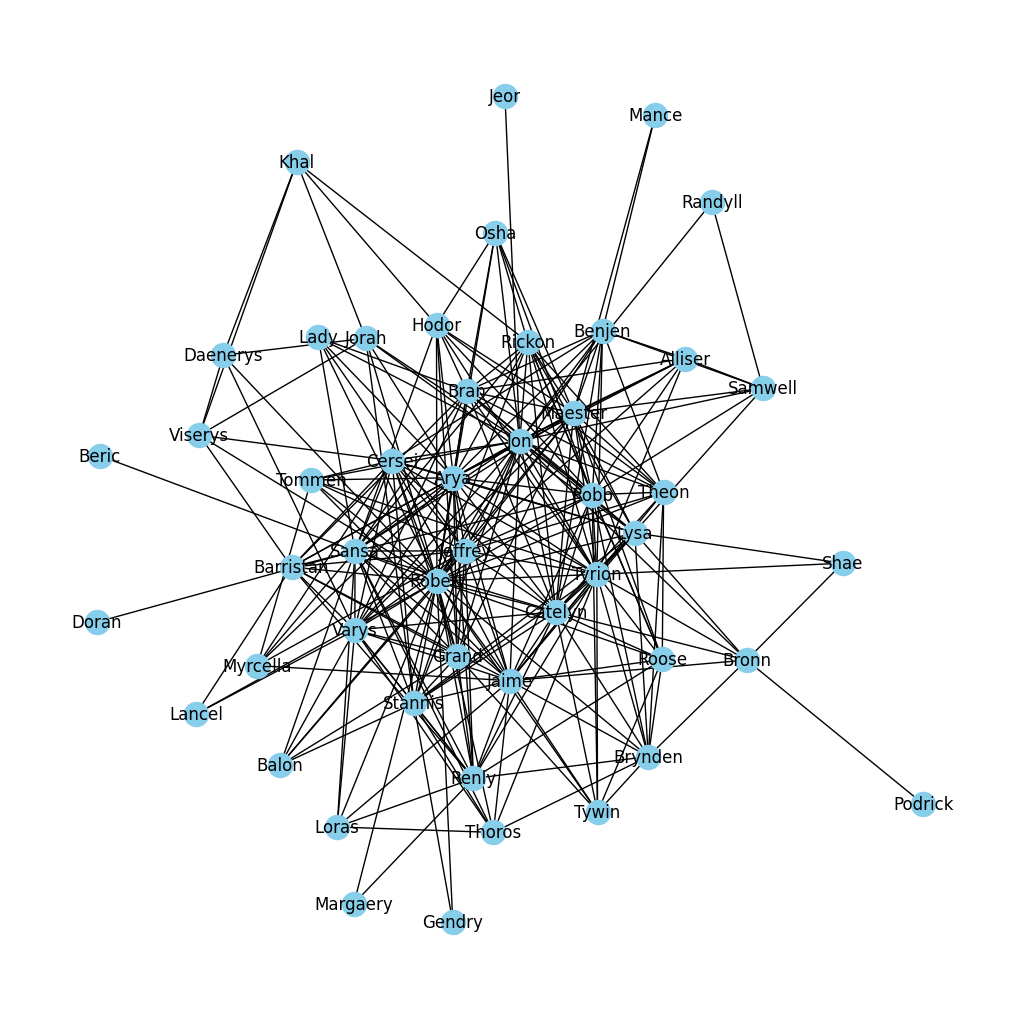

In [23]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [33]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#000000', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
net.repulsion()

net.from_nx(G)
net.show("got.html")

got.html


In [25]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Jon': 0.5833333333333333,
 'Robert': 0.75,
 'Robb': 0.41666666666666663,
 'Bran': 0.375,
 'Theon': 0.2708333333333333,
 'Rickon': 0.29166666666666663,
 'Catelyn': 0.4583333333333333,
 'Sansa': 0.5,
 'Maester': 0.4375,
 'Brynden': 0.25,
 'Lysa': 0.3125,
 'Daenerys': 0.10416666666666666,
 'Viserys': 0.125,
 'Khal': 0.10416666666666666,
 'Jorah': 0.16666666666666666,
 'Cersei': 0.35416666666666663,
 'Jaime': 0.47916666666666663,
 'Benjen': 0.2708333333333333,
 'Joffrey': 0.4375,
 'Tommen': 0.16666666666666666,
 'Arya': 0.5,
 'Tyrion': 0.5208333333333333,
 'Myrcella': 0.125,
 'Barristan': 0.2708333333333333,
 'Hodor': 0.22916666666666666,
 'Lady': 0.125,
 'Stannis': 0.3333333333333333,
 'Renly': 0.3125,
 'Varys': 0.3958333333333333,
 'Loras': 0.125,
 'Alliser': 0.1875,
 'Jeor': 0.020833333333333332,
 'Grand': 0.29166666666666663,
 'Samwell': 0.14583333333333331,
 'Randyll': 0.041666666666666664,
 'Margaery': 0.041666666666666664,
 'Thoros': 0.16666666666666666,
 'Lancel': 0.0625,
 'Gendr

<AxesSubplot: >

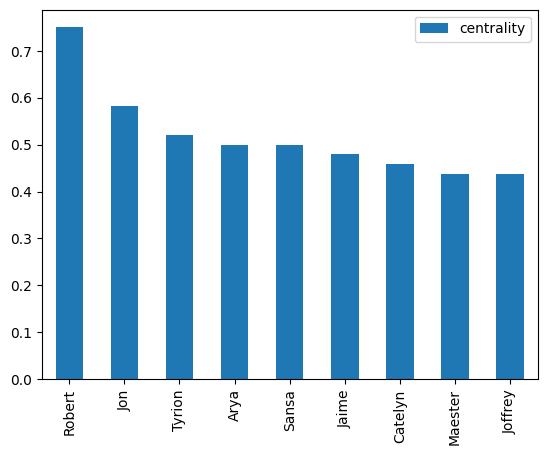

In [26]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [27]:
import community as community_louvain
communities = community_louvain.best_partition(G)

In [28]:
communities

{'Jon': 3,
 'Robert': 1,
 'Robb': 2,
 'Bran': 3,
 'Theon': 2,
 'Rickon': 2,
 'Catelyn': 2,
 'Sansa': 1,
 'Maester': 3,
 'Brynden': 2,
 'Lysa': 2,
 'Daenerys': 1,
 'Viserys': 1,
 'Khal': 1,
 'Jorah': 1,
 'Cersei': 0,
 'Jaime': 2,
 'Benjen': 3,
 'Joffrey': 0,
 'Tommen': 0,
 'Arya': 0,
 'Tyrion': 2,
 'Myrcella': 0,
 'Barristan': 1,
 'Hodor': 3,
 'Lady': 0,
 'Stannis': 1,
 'Renly': 1,
 'Varys': 1,
 'Loras': 1,
 'Alliser': 3,
 'Jeor': 3,
 'Grand': 1,
 'Samwell': 3,
 'Randyll': 3,
 'Margaery': 1,
 'Thoros': 1,
 'Lancel': 1,
 'Gendry': 1,
 'Bronn': 2,
 'Roose': 2,
 'Mance': 3,
 'Tywin': 2,
 'Beric': 1,
 'Balon': 1,
 'Osha': 3,
 'Doran': 1,
 'Podrick': 2,
 'Shae': 2}

In [29]:
nx.set_node_attributes(G, communities, 'group')

In [35]:
com_net = Network(notebook = True, width="1080px", height="720px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.repulsion()
com_net.show("Got2.html")

Got2.html
